In [ ]:
#extended to 1+1 shared path protection
#After finding the best path for each traffic request, identify the links that are used in the primary path.
#For each link in the primary path, find an alternative path between the same source and destination nodes that doesn't use that link.
#Evaluate the alternative paths and select the best one based on some criteria (e.g., shortest length, lowest cost).
#Assign modulation formats and spectrum slots for both the primary and backup paths.
#Repeat this process for each traffic request.

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import math




def read_topology_file(file_path):
    # Create an empty graph
    G = nx.Graph()

    # Read the topology file line by line
    with open(file_path, 'r') as file:
        next(file)  # Skip the header line
        for line in file:
            # Split the line into fields
            fields = line.strip().split()

            # Extract relevant information
            node_a = int(fields[3])
            node_b = int(fields[4])
            length = int(fields[5])

            # Add an edge to the graph with the nodes and length
            G.add_edge(node_a, node_b, length=length)

    return G

def plot_topology(graph):
    pos = nx.spring_layout(graph,seed=1)  # Positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, width=2)

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family="sans-serif")

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(graph, 'length')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    plt.axis("off")
    plt.show()


# Example usage:
file_path = 'Germany-7nodes\G7-topology.txt'  # Replace 'topology.txt' with the actual file path
topology_graph = read_topology_file(file_path)
#plot_topology(topology_graph)
# Print basic information about the graph
print("Number of nodes:", topology_graph.number_of_nodes())
print("Number of edges:", topology_graph.number_of_edges())


Number of nodes: 7
Number of edges: 11


In [32]:
def read_traffic_request(file_path):
    traffic_matrix = []
    
    with open(file_path, 'r') as file:
        for line in file:
            row = list(map(int, line.strip().split()))
            traffic_matrix.append(row)
    
    return traffic_matrix

# Example usage:
file_path = 'Germany-7nodes\G7-matrix-1.txt'  # Replace 'traffic_request.txt' with the actual file path
traffic_matrix = read_traffic_request(file_path)

# Print the traffic matrix
for row in traffic_matrix:
    print(row)


[0, 7, 10, 11, 0, 29, 18]
[14, 0, 15, 28, 17, 8, 10]
[0, 12, 0, 1, 12, 1, 5]
[11, 16, 33, 0, 8, 8, 20]
[6, 22, 13, 14, 0, 8, 9]
[0, 29, 6, 16, 15, 0, 19]
[28, 10, 8, 33, 1, 6, 0]


In [33]:
def calculate_k_shortest_paths(graph, source, target, k):
    return list(nx.shortest_simple_paths(graph, source, target, weight='length'))[:k]

k=5
# Calculate k shortest paths for each traffic request
for i in range(len(traffic_matrix)):
    for j in range(len(traffic_matrix[i])):
        if traffic_matrix[i][j] != 0:
            source = i + 1  # Assuming 1-based indexing
            target = j + 1  # Assuming 1-based indexing
            k_shortest_paths = calculate_k_shortest_paths(topology_graph, source, target, k)
            print(f"Shortest paths from node {source} to node {target}:")
            for idx, path in enumerate(k_shortest_paths):
                print(f"Path {idx + 1}: {path}")

Shortest paths from node 1 to node 2:
Path 1: [1, 2]
Path 2: [1, 3, 2]
Path 3: [1, 3, 4, 2]
Path 4: [1, 3, 5, 4, 2]
Path 5: [1, 3, 6, 5, 4, 2]
Shortest paths from node 1 to node 3:
Path 1: [1, 3]
Path 2: [1, 2, 3]
Path 3: [1, 2, 4, 3]
Path 4: [1, 2, 4, 5, 3]
Path 5: [1, 2, 4, 5, 6, 3]
Shortest paths from node 1 to node 4:
Path 1: [1, 3, 4]
Path 2: [1, 2, 4]
Path 3: [1, 3, 5, 4]
Path 4: [1, 2, 3, 4]
Path 5: [1, 3, 2, 4]
Shortest paths from node 1 to node 6:
Path 1: [1, 3, 6]
Path 2: [1, 2, 3, 6]
Path 3: [1, 3, 5, 6]
Path 4: [1, 3, 5, 7, 6]
Path 5: [1, 2, 3, 5, 6]
Shortest paths from node 1 to node 7:
Path 1: [1, 3, 5, 7]
Path 2: [1, 3, 6, 7]
Path 3: [1, 2, 3, 5, 7]
Path 4: [1, 2, 3, 6, 7]
Path 5: [1, 3, 4, 5, 7]
Shortest paths from node 2 to node 1:
Path 1: [2, 1]
Path 2: [2, 3, 1]
Path 3: [2, 4, 3, 1]
Path 4: [2, 4, 5, 3, 1]
Path 5: [2, 4, 5, 6, 3, 1]
Shortest paths from node 2 to node 3:
Path 1: [2, 3]
Path 2: [2, 1, 3]
Path 3: [2, 4, 3]
Path 4: [2, 4, 5, 3]
Path 5: [2, 4, 5, 6, 3]
Sh

In [34]:
# Define modulation format options and their parameters
modulation_formats = {
    'SC-DP-QPSK': {'line_rate': 100, 'channel_bandwidth': 37.5, 'max_length': 2000, 'transponder_cost': 1.5},
    'DP-QPSK': {'line_rate': 200, 'channel_bandwidth': 37.5, 'max_length': 700, 'transponder_cost': 2},
    'DP-16QAM':{'line_rate': 400, 'channel_bandwidth': 75, 'max_length': 500, 'transponder_cost': 3.7}
}



def assign_modulation_format(shortest_path, graph_dict, modulation_formats, traffic_request):
    assigned_modulation_formats = []
    total_length=0
    for i in range(len(shortest_path) - 1):
        node_a = shortest_path[i]
        node_b = shortest_path[i + 1]
        if node_a in graph_dict and node_b in graph_dict[node_a]:
            length = graph_dict[node_a][node_b]['length']
            total_length += length  # Add the length of the current edge to total length
        else:
            raise Exception(f"Edge ({node_a}, {node_b}) does not exist in the graph.")
    
            
    feasible_formats = []
        
    for format_name, params in modulation_formats.items():
        if total_length <= params['max_length']:
            #print(total_length)
            num_links_required = math.ceil(traffic_request * 10 / params['line_rate'])
            # Calculate the cost for the modulation format considering the number of links required
            total_cost = num_links_required * params['transponder_cost']
            feasible_formats.append((format_name, total_cost,num_links_required))
    if not feasible_formats:
        raise Exception(f"No feasible modulation format for link ({node_a}, {node_b})")
    
    # Select the format with minimum cost
    selected_format, min_cost,num_links = min(feasible_formats, key=lambda x: x[1])
    assigned_modulation_formats.append((shortest_path, selected_format,min_cost,num_links))
    
            # Handle this case as needed
    return assigned_modulation_formats


# Example usage:
assigned_formats_matrix = []
for i in range(len(traffic_matrix)):
    for j in range(len(traffic_matrix[i])):
        if traffic_matrix[i][j] != 0:
            source = i + 1  # Assuming 1-based indexing
            target = j + 1  # Assuming 1-based indexing
            traffic_request = traffic_matrix[i][j]  # Get traffic request from the matrix
            shortest_paths = calculate_k_shortest_paths(topology_graph, source, target, k)
            min_cost = float('inf')
            best_path = None
            best_modulation = None
            for path in shortest_paths:
                #print(path)
                assigned_formats = assign_modulation_format(path,topology_graph, modulation_formats, traffic_request)
                for path, _, cost,link in assigned_formats:
                    if cost < min_cost:
                        min_cost = cost
                        best_path = path
                        best_modulation = _
                        best_link=link
            assigned_formats_matrix.append((i, j, best_path, best_modulation,best_link,min_cost))

# Print the assigned formats for each traffic request
for i, j, path, modulation,link,cost in assigned_formats_matrix:
    print(f"Traffic request ({i+1}, {j+1}):")
    print("Shortest path:", path)
    print("Assigned modulation formats:", modulation)
    #print("used number of link",link)
    print("transponder cost ",cost)




Traffic request (1, 2):
Shortest path: [1, 2]
Assigned modulation formats: SC-DP-QPSK
transponder cost  1.5
Traffic request (1, 3):
Shortest path: [1, 3]
Assigned modulation formats: SC-DP-QPSK
transponder cost  1.5
Traffic request (1, 4):
Shortest path: [1, 3, 4]
Assigned modulation formats: DP-QPSK
transponder cost  2
Traffic request (1, 6):
Shortest path: [1, 3, 6]
Assigned modulation formats: DP-16QAM
transponder cost  3.7
Traffic request (1, 7):
Shortest path: [1, 3, 5, 7]
Assigned modulation formats: DP-QPSK
transponder cost  2
Traffic request (2, 1):
Shortest path: [2, 1]
Assigned modulation formats: DP-QPSK
transponder cost  2
Traffic request (2, 3):
Shortest path: [2, 3]
Assigned modulation formats: DP-QPSK
transponder cost  2
Traffic request (2, 4):
Shortest path: [2, 4]
Assigned modulation formats: DP-16QAM
transponder cost  3.7
Traffic request (2, 5):
Shortest path: [2, 3, 5]
Assigned modulation formats: DP-QPSK
transponder cost  2
Traffic request (2, 6):
Shortest path: [2,

In [35]:
#find alternative 1+1 path for the best path
#two ways to choose from alternative path(random/shortest)

import random

def choose_shortest_alternative_path(alternative_paths):
    if not alternative_paths:
        return None
    shortest_path = min(alternative_paths, key=len)
    return shortest_path

def choose_random_alternative_path(alternative_paths):
    if not alternative_paths:
        return None
    return random.choice(alternative_paths)

def find_alternative_path(primary_path, topology_graph):
    #find all alternative path
    source, target = primary_path[0], primary_path[-1]
    alternative_paths = []
    
    all_simple_paths = list(nx.all_simple_paths(topology_graph, source, target))
    
    for path in all_simple_paths:
        if path == primary_path:
            continue
        # Check if the path avoids nodes in the primary path
        if any(node in primary_path[1:-1] for node in path[1:-1]):
            continue  # Skip paths that include nodes from the primary path
        alternative_paths.append(path)
    
    return alternative_paths




In [36]:
import numpy as np

def find_corresponding_row(topology_graph, link):
    # Find the index of the link in the list of edges
    edges = list(topology_graph.edges())
    try:
        index = edges.index(link)
    except ValueError:
        # Reverse the link and try again (in case the order is different)
        reversed_link = (link[1], link[0])
        index = edges.index(reversed_link)+11
        #index = edges.index(reversed_link)+15  
                #11 for German 15 Italian
    return index


def calculate_num_slots_needed(modulation):
    # Calculate the number of slots needed based on modulation
    if modulation == "SC-DP-QPSK":
        return 3
    elif modulation == "DP-QPSK":
        return 3
    elif modulation == "DP-16QAM":
        return 6
    # Add more cases for other modulations as needed
    else:
        return 0  # Default to 0 slots needed if modulation is unknown
    

    
def create_spectrum_matrix(topology_graph, num_spectrum_slots):
    num_links = len(topology_graph.edges())*2
    return np.zeros((num_links, num_spectrum_slots), dtype=int)

def break_down_path_to_links(path):
    links = []
    for i in range(len(path) - 1):
        link = (path[i], path[i + 1])
        links.append(link)
    return links


def assign_spectrum_for_request(path,alternative_path,topology_graph ,spectrum_matrix, modulation, num_link):
    #change: take both path and alternative path, and take alternative path into consideration when finding available slot
    num_slots_needed = calculate_num_slots_needed(modulation)*num_link
    links = break_down_path_to_links(path)
    if alternative_path is not None:
        al_link = break_down_path_to_links(alternative_path)
        links.extend(al_link)
    # Find the corresponding row(s) in the spectrum matrix for the links in the path
    row_indices = [find_corresponding_row(topology_graph,link) for link in links]
    start_slot = find_available_slots(spectrum_matrix, row_indices, num_slots_needed)


    if start_slot is not None:
        # Assign the spectrum slots
        for row_index in row_indices:
            for i in range(num_slots_needed):
                spectrum_matrix[row_index][start_slot + i] = 1

        print(f"Assigned spectrum slots for path {path} (Modulation: {modulation}): {start_slot} - {start_slot + num_slots_needed - 1}")
        print(f"Assigned spectrum slots for alternative path {alternative_path} : {start_slot} - {start_slot + num_slots_needed - 1}")
        return start_slot
    else:
        print(f"No available spectrum slots for path {path}")
    # If no available slots are found on any link, return None
    return None


def find_available_slots(spectrum_matrix, row_indices, num_slots_needed):
    available_slots = []

    for j in range(320 - num_slots_needed + 1):
        is_available = True
        for row_index in row_indices:

        # Get the corresponding row from the spectrum matrix
            row = spectrum_matrix[row_index]
            if any(row[j + k] != 0 for k in range((num_slots_needed))):
                is_available = False
                break
            if not is_available:
                break


        if is_available:
            return j
    
    return None  # Return None if no available slots are found
                




In [37]:
spectrum_matrix=create_spectrum_matrix(topology_graph,num_spectrum_slots=320)
all_alternative_paths=[]
for i,j,path, modulation,link ,cost in assigned_formats_matrix:
    primary_path=path
    alternative_paths = find_alternative_path(primary_path, topology_graph)
    al_path=choose_shortest_alternative_path(alternative_paths)
    all_alternative_paths.append(al_path)
    assign_spectrum_for_request(path,al_path,topology_graph,spectrum_matrix,modulation,link)

Assigned spectrum slots for path [1, 2] (Modulation: SC-DP-QPSK): 0 - 2
Assigned spectrum slots for alternative path [1, 3, 2] : 0 - 2
Assigned spectrum slots for path [1, 3] (Modulation: SC-DP-QPSK): 3 - 5
Assigned spectrum slots for alternative path [1, 2, 3] : 3 - 5
Assigned spectrum slots for path [1, 3, 4] (Modulation: DP-QPSK): 6 - 8
Assigned spectrum slots for alternative path [1, 2, 4] : 6 - 8
Assigned spectrum slots for path [1, 3, 6] (Modulation: DP-16QAM): 9 - 14
Assigned spectrum slots for alternative path [1, 2, 4, 5, 6] : 9 - 14
Assigned spectrum slots for path [1, 3, 5, 7] (Modulation: DP-QPSK): 15 - 17
Assigned spectrum slots for alternative path None : 15 - 17
Assigned spectrum slots for path [2, 1] (Modulation: DP-QPSK): 0 - 2
Assigned spectrum slots for alternative path [2, 3, 1] : 0 - 2
Assigned spectrum slots for path [2, 3] (Modulation: DP-QPSK): 18 - 20
Assigned spectrum slots for alternative path [2, 1, 3] : 18 - 20
Assigned spectrum slots for path [2, 4] (Modul

In [38]:
def calculate_link_usage(assigned_formats_matrix, al_path, topology_graph):
    link_usage = np.zeros(len(topology_graph.edges())*2)
    edges = list(topology_graph.edges())
    for _, _, path, _, _,_ in assigned_formats_matrix:
        all_paths = [path, al_path] if al_path else [path]

        for path in all_paths:
            links = break_down_path_to_links(path)
            for link in links:
                try:
                    index = edges.index(link)
                except ValueError:
            # Reverse the link and try again (in case the order is different)
                    reversed_link = (link[1], link[0])
                    index = edges.index(reversed_link)+11
                    #index = edges.index(reversed_link)+15  
                    #11 for German 15 Italian
                link_usage[index]+=1
    
    return link_usage


link_usage=calculate_link_usage(assigned_formats_matrix,al_path,topology_graph)

for i, usage_count in enumerate(link_usage):
    print(f"Link usage on edge {i+1}: {usage_count}")

Link usage on edge 1: 1.0
Link usage on edge 2: 4.0
Link usage on edge 3: 4.0
Link usage on edge 4: 1.0
Link usage on edge 5: 2.0
Link usage on edge 6: 5.0
Link usage on edge 7: 3.0
Link usage on edge 8: 3.0
Link usage on edge 9: 41.0
Link usage on edge 10: 5.0
Link usage on edge 11: 1.0
Link usage on edge 12: 1.0
Link usage on edge 13: 3.0
Link usage on edge 14: 4.0
Link usage on edge 15: 1.0
Link usage on edge 16: 2.0
Link usage on edge 17: 6.0
Link usage on edge 18: 2.0
Link usage on edge 19: 3.0
Link usage on edge 20: 2.0
Link usage on edge 21: 44.0
Link usage on edge 22: 1.0


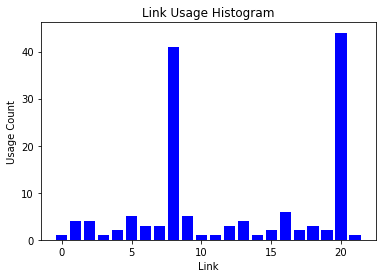

In [39]:
def plot_link_usage_histogram(link_usage):
    num_edges = len(link_usage)
    edges = range(num_edges)
    
    plt.bar(edges, link_usage, color='blue')
    plt.xlabel('Link')
    plt.ylabel('Usage Count')
    plt.title('Link Usage Histogram')
    plt.show()

# Assuming 'link_usage' is the output from calculate_link_usage function
plot_link_usage_histogram(link_usage)

In [40]:
def calculate_path_lengths(assigned_formats_matrix, al_path,graph_dict):
    path_lengths = []
    for _, _, path, _, _ ,_ in assigned_formats_matrix:
        all_paths = [path, al_path] if al_path else [path]

        for path in all_paths:
            total_length = 0
            for i in range(len(path) - 1):
                node_a = path[i]
                node_b = path[i + 1]
                if node_a in graph_dict and node_b in graph_dict[node_a]:
                    length = graph_dict[node_a][node_b]['length']
                    total_length += length
            path_lengths.append(total_length)
    return path_lengths

# Assuming 'assigned_formats_matrix' is the output from the previous steps
# Assuming 'graph_dict' is a dictionary containing the lengths of edges in the topology graph
path_lengths = calculate_path_lengths(assigned_formats_matrix,al_path, topology_graph)

for length in path_lengths:
    print("Path length:", length)


Path length: 114
Path length: 628
Path length: 120
Path length: 628
Path length: 418
Path length: 628
Path length: 436
Path length: 628
Path length: 653
Path length: 628
Path length: 114
Path length: 628
Path length: 157
Path length: 628
Path length: 306
Path length: 628
Path length: 415
Path length: 628
Path length: 473
Path length: 628
Path length: 690
Path length: 628
Path length: 157
Path length: 628
Path length: 298
Path length: 628
Path length: 258
Path length: 628
Path length: 316
Path length: 628
Path length: 533
Path length: 628
Path length: 418
Path length: 628
Path length: 306
Path length: 628
Path length: 298
Path length: 628
Path length: 174
Path length: 628
Path length: 527
Path length: 628
Path length: 449
Path length: 628
Path length: 378
Path length: 628
Path length: 415
Path length: 628
Path length: 258
Path length: 628
Path length: 174
Path length: 628
Path length: 353
Path length: 628
Path length: 275
Path length: 628
Path length: 473
Path length: 628
Path length: 3

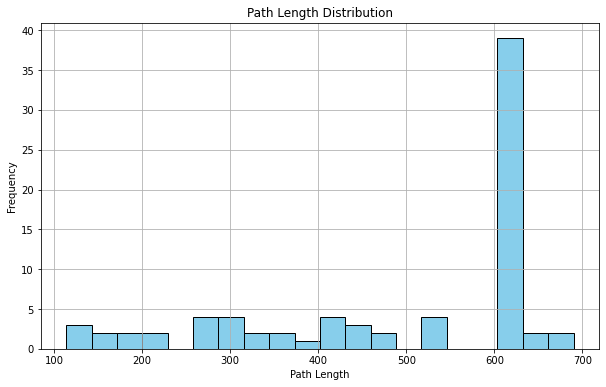

In [41]:
import matplotlib.pyplot as plt

# Assuming 'path_lengths' contains the path lengths calculated previously

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(path_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Path Length Distribution')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0]
 [1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0]
 [1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1

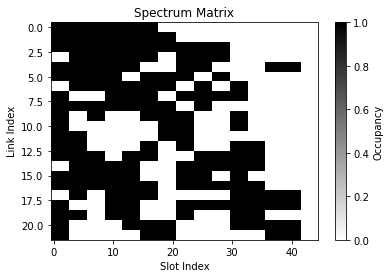

In [42]:
import sys
np.set_printoptions(threshold=sys.maxsize)

print(spectrum_matrix[:, :30])

def visualize_spectrum_matrix(spectrum_matrix):
    spectrum_matrix_subset = spectrum_matrix[:, :45]
    plt.imshow(spectrum_matrix_subset, cmap='binary', aspect='auto')
    plt.xlabel('Slot Index')
    plt.ylabel('Link Index')
    plt.title('Spectrum Matrix')
    plt.colorbar(label='Occupancy')
    plt.show()

# Assuming 'spectrum_matrix' is your spectrum matrix
visualize_spectrum_matrix(spectrum_matrix)

In [43]:
def find_alternative_path(primary_path, topology_graph):
    #find all alternative path
    source, target = primary_path[0], primary_path[-1]
    alternative_paths = []
    
    all_simple_paths = list(nx.all_simple_paths(topology_graph, source, target))
    
    for path in all_simple_paths:
        # Check if the path avoids nodes in the primary path
        if path == primary_path:
            continue
        if any(node in primary_path[1:-1] for node in path[1:-1]):
            continue  # Skip paths that include nodes from the primary path
        alternative_paths.append(path)
    
    return alternative_paths

#path=[2,4]
#print(find_alternative_path(path,topology_graph))

for i,j,path, modulation,link,cost in assigned_formats_matrix:
    primary_path=path
    alternative_paths = find_alternative_path(primary_path, topology_graph)
    al_path=choose_random_alternative_path(alternative_paths)
    all_alternative_paths.append(al_path)
    print(al_path)

[1, 3, 6, 5, 4, 2]
[1, 2, 4, 3]
[1, 2, 4]
[1, 2, 4, 5, 7, 6]
None
[2, 4, 3, 1]
[2, 4, 5, 7, 6, 3]
[2, 3, 4]
[2, 4, 5]
[2, 4, 5, 6]
None
[3, 5, 4, 2]
[3, 5, 4]
[3, 2, 4, 5]
[3, 4, 5, 7, 6]
[3, 6, 7]
[4, 2, 1]
[4, 5, 3, 1, 2]
[4, 5, 6, 3]
[4, 2, 3, 6, 7, 5]
[4, 3, 6]
[4, 2, 1, 3, 6, 7]
[5, 4, 2, 1]
[5, 4, 2]
[5, 6, 3]
[5, 7, 6, 3, 1, 2, 4]
[5, 3, 6]
[5, 4, 2, 1, 3, 6, 7]
[6, 7, 5, 4, 2]
[6, 5, 4, 3]
[6, 3, 1, 2, 4]
[6, 7, 5]
[6, 3, 4, 5, 7]
None
None
[7, 6, 3]
[7, 6, 3, 1, 2, 4]
[7, 6, 3, 1, 2, 4, 5]
[7, 5, 3, 6]


highest fsu on link  1: 17
highest fsu on link  2: 20
highest fsu on link  3: 29
highest fsu on link  4: 29
highest fsu on link  5: 41
highest fsu on link  6: 29
highest fsu on link  7: 32
highest fsu on link  8: 32
highest fsu on link  9: 26
highest fsu on link  10: 32
highest fsu on link  11: 32
highest fsu on link  12: 23
highest fsu on link  13: 35
highest fsu on link  14: 35
highest fsu on link  15: 35
highest fsu on link  16: 32
highest fsu on link  17: 35
highest fsu on link  18: 41
highest fsu on link  19: 41
highest fsu on link  20: 35
highest fsu on link  21: 41
highest fsu on link  22: 41


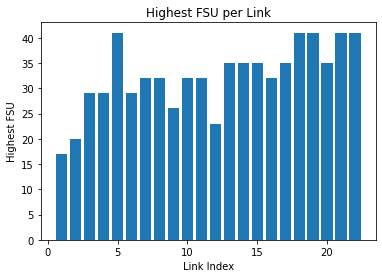

In [44]:
def calculate_highest_used_slot_per_link(spectrum_matrix):
    highest_used_slots = []
    for row in spectrum_matrix:
        highest_used_slot = max((i for i, val in enumerate(row) if val == 1), default=-1)
        highest_used_slots.append(highest_used_slot)
    return highest_used_slots

highest_used_fsu=calculate_highest_used_slot_per_link(spectrum_matrix)
for i, usage_count in enumerate(highest_used_fsu):
    print(f"highest fsu on link  {i+1}: {usage_count}")

plt.bar(range(1, len(highest_used_fsu) + 1), highest_used_fsu)
plt.xlabel('Link Index')
plt.ylabel('Highest FSU')
plt.title('Highest FSU per Link')
plt.show()

In [45]:
def calculate_total_used_fsus(spectrum_matrix):
    total_used_fsus = sum(sum(row) for row in spectrum_matrix)
    return total_used_fsus

total_used_fsu=calculate_total_used_fsus(spectrum_matrix)
print("total number of used fsu:",total_used_fsu)

total number of used fsu: 501


Transponder Costs:
Path 1: 1.5
Path 2: 1.5
Path 3: 2
Path 4: 3.7
Path 5: 2
Path 6: 2
Path 7: 2
Path 8: 3.7
Path 9: 2
Path 10: 1.5
Path 11: 1.5
Path 12: 2
Path 13: 1.5
Path 14: 2
Path 15: 1.5
Path 16: 1.5
Path 17: 2
Path 18: 2
Path 19: 3.7
Path 20: 1.5
Path 21: 1.5
Path 22: 2
Path 23: 1.5
Path 24: 3.7
Path 25: 2
Path 26: 2
Path 27: 1.5
Path 28: 1.5
Path 29: 3.7
Path 30: 1.5
Path 31: 2
Path 32: 2
Path 33: 2
Path 34: 4
Path 35: 1.5
Path 36: 1.5
Path 37: 3.7
Path 38: 1.5
Path 39: 1.5
Path 40: 1.5
Path 41: 1.5
Path 42: 2
Path 43: 3.7
Path 44: 2
Path 45: 2
Path 46: 2
Path 47: 3.7
Path 48: 2
Path 49: 1.5
Path 50: 1.5
Path 51: 2
Path 52: 1.5
Path 53: 2
Path 54: 1.5
Path 55: 1.5
Path 56: 2
Path 57: 2
Path 58: 3.7
Path 59: 1.5
Path 60: 1.5
Path 61: 2
Path 62: 1.5
Path 63: 3.7
Path 64: 2
Path 65: 2
Path 66: 1.5
Path 67: 1.5
Path 68: 3.7
Path 69: 1.5
Path 70: 2
Path 71: 2
Path 72: 2
Path 73: 4
Path 74: 1.5
Path 75: 1.5
Path 76: 3.7
Path 77: 1.5
Path 78: 1.5


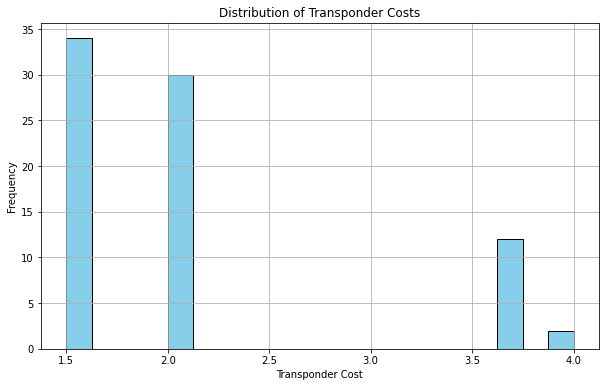

In [46]:
#since the alternative path has same number of link usage modulation and spectrum slot as primary path
#the transponder cost will be double

transponder_costs = [path_data[5] for path_data in assigned_formats_matrix]*2

# Printing the transponder costs
print("Transponder Costs:")
for i, cost in enumerate(transponder_costs, start=1):
    print(f"Path {i}: {cost}")

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(transponder_costs, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Transponder Costs')
plt.xlabel('Transponder Cost')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
#below is test demo code to test whether my algorithm works, please ingnore

In [59]:
edges_list = list(topology_graph.edges())
if (2, 4) in edges_list:
    print("Edge (2, 4) exists in the graph.")
else:
    print("Edge (2, 4) does not exist in the graph.")

path=[1,3,4]
link=break_down_path_to_links(path)
print(link)
row_indices = [find_corresponding_row(topology_graph,link) for link in link]
print(row_indices)

Edge (2, 4) exists in the graph.
[(1, 3), (3, 4)]
[1, 4]
